# Capstone EDA

## Importing Necessary Modules

In [4]:
!pip3 install -q numpy==1.21.6
!pip3 install -q basemap
!pip3 install -q ipython-autotime
!pip3 install -q pandas
!pip3 install -q polars
!pip3 install -q pyarrow
!pip3 install -q requests
!pip3 install -q seaborn
!pip3 install -q tqdm

%load_ext autotime

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basemap 1.3.6 requires numpy<1.24,>=1.22; python_version >= "3.8", but you have numpy 1.21.6 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.
time: 557 µs (started: 2023-01-22 17:18:03 +00:00)


In [5]:
import csv
import datetime as dt
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

time: 2.55 s (started: 2023-01-22 17:18:03 +00:00)


## Download Data Files

In [3]:
import os
import requests
import shutil
from tqdm.auto import tqdm

def download_file_s3(s3_url: str, name: str = None):
    # make an HTTP request within a context manager
    with requests.get(s3_url, stream=True) as r:
        
        # check header to get content length, in bytes
        total_length = int(r.headers.get("Content-Length"))
        
        # implement progress bar via tqdm
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc="") as raw:
        
            # save the output to a file
            name = f"{os.path.basename(r.url)}" if not name else name
            with open(name, 'wb') as output:
                shutil.copyfileobj(raw, output)

time: 234 ms (started: 2023-01-22 13:42:03 +00:00)


In [4]:
data_files = {"NonEventData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/noneventdata/non_event_data.csv",
              "EventData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/eventdata/event_data.csv", 
              "AppData": "https://ravigorticapstonebucket.s3.amazonaws.com/Captsone/appdata/app_data.csv"}

# Checking if the files are already downloaded.
for file_name, file_s3_url in data_files.items():
    file_name += ".csv"
    if not os.path.exists(file_name):
        print(f"Downloading data file '{file_name[:-4]}' from '{file_s3_url}'")
        download_file_s3(s3_url=file_s3_url, name=file_name)

time: 3.55 ms (started: 2023-01-22 13:42:04 +00:00)


## Load Data

### Non-Event Data

In [5]:
df_columns = ["device_id", "gender", "age", "group_train", "phone_brand", "device_model"]
non_event_data_df = pl.scan_csv("NonEventData.csv", 
                                with_column_names=lambda cols: [df_columns[idx] for idx, _ in enumerate(cols)],
                                parse_dates=True, 
                                ignore_errors=True)

time: 7.75 ms (started: 2023-01-22 13:42:04 +00:00)


In [6]:
non_event_data_df.head().collect(streaming=True)

device_id,gender,age,group_train,phone_brand,device_model
i64,str,i64,str,str,str
6943568600617760000,"""M""",37,"""M32+""","""Xiaomi""","""xnote"""
5441349705980020000,"""M""",40,"""M32+""","""OPPO""","""R7s"""
-5393876656119450000,"""M""",33,"""M32+""","""Xiaomi""","""MI 4"""
4543988487649880000,"""M""",53,"""M32+""","""samsung""","""Galaxy S4"""
-1819925713085810000,"""F""",23,"""F0-24""","""OPPO""","""N1 Mini"""


time: 7.21 ms (started: 2023-01-22 13:42:04 +00:00)


### Event Data

In [6]:
df_columns = ["device_id", "gender", "age", "group_train", "event_id", "time_stamp", "longitude", "latitude"]
event_data_df = pl.scan_csv("EventData.csv", 
                             with_column_names=lambda cols: [df_columns[idx] for idx, _ in enumerate(cols)],
                             parse_dates=True, 
                             ignore_errors=True)

time: 104 ms (started: 2023-01-22 17:18:17 +00:00)


In [7]:
event_data_df.head().collect(streaming=True)

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude
i64,str,i64,str,i64,datetime[μs],f64,f64
-7548291590301750000,"""M""",33,"""M32+""",2939192,2016-05-05 10:12:40,116.79,33.98
-7548291590301750000,"""M""",33,"""M32+""",2935402,2016-05-04 08:47:19,116.79,33.98
-7548291590301750000,"""M""",33,"""M32+""",2906259,2016-05-01 11:00:08,116.79,33.98
-7548291590301750000,"""M""",33,"""M32+""",2904274,2016-05-01 10:15:23,116.79,33.98
-7548291590301750000,"""M""",33,"""M32+""",2897002,2016-05-04 03:33:24,116.79,33.98


time: 135 ms (started: 2023-01-22 17:18:18 +00:00)


### App Data

In [9]:
DEBUG_MODE = True

# Loading the entire AppData to get the total size
app_data_df = pl.scan_csv("AppData.csv", quote_char=None, ignore_errors=True)
total_num_records = app_data_df.select([pl.count()]).collect(streaming=True).get_column('count').to_list()[0]

if DEBUG_MODE:
    percentage_of_records_to_select = 0.2
    print(f"Loading AppData in DEBUG MODE with {percentage_of_records_to_select * 100}% of records.")

    num_records_to_be_selected = int(percentage_of_records_to_select * total_num_records)

    print(f"Total number of records in the App Data is {total_num_records}.", 
        f"Loading only top {percentage_of_records_to_select * 100}%,", 
        f"i.e. {num_records_to_be_selected} records")
else:
    num_records_to_be_selected = total_num_records
    print(f"Loading the entire AppData with {num_records_to_be_selected} records.")

Loading AppData in DEBUG MODE with 20.0% of records.
Total number of records in the App Data is 198119242. Loading only top 20.0%, i.e. 39623848 records
time: 1min 14s (started: 2023-01-22 13:42:04 +00:00)


In [10]:
# Deleting `temp` variable(s) and running garbage collection.
del app_data_df
gc.collect()

0

time: 96.9 ms (started: 2023-01-22 13:43:19 +00:00)


In [11]:
# Loading AppData in Lazy mode for further usage and also with a limit on the number of records that is considered.
df_columns = ['event_id', 'app_id', 'is_installed', 'is_active', 'label_id', 'category']
app_data_df = pl.scan_csv("AppData.csv", 
                              with_column_names=lambda cols: [df_columns[idx] for idx, _ in enumerate(cols)],
                              n_rows=num_records_to_be_selected, 
                              parse_dates=True, 
                              ignore_errors=True)

time: 11.4 ms (started: 2023-01-22 13:43:19 +00:00)


In [12]:
app_data_df.head().collect(streaming=True)

event_id,app_id,is_installed,is_active,label_id,category
i64,i64,i64,i64,i64,str
3127265,-5924787280098922359,1,1,548,"""Industry tag"""
3127265,-5924787280098922359,1,1,704,"""Property Indus..."
3127267,5927333115845830913,1,1,549,"""Property Indus..."
3127267,5927333115845830913,1,1,172,"""IM"""
3127267,5927333115845830913,1,1,548,"""Industry tag"""


time: 9.07 ms (started: 2023-01-22 13:43:19 +00:00)


In [13]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

0

time: 89.6 ms (started: 2023-01-22 13:43:19 +00:00)


## EDA

### Data Cleaning for EventData

In [14]:
def show_missing_value_details(df: pl.DataFrame):
    for col in df.collect().get_columns():
        print(f"{col.name:<15}: {col.is_null().sum():<10} : {col.is_null().sum()*100/col.len():.5f}%")

time: 1.09 ms (started: 2023-01-22 13:43:19 +00:00)


In [15]:
show_missing_value_details(event_data_df)

device_id      : 0          : 0.00000%
gender         : 0          : 0.00000%
age            : 0          : 0.00000%
group_train    : 0          : 0.00000%
event_id       : 51335      : 4.05191%
time_stamp     : 51335      : 4.05191%
longitude      : 51335      : 4.05191%
latitude       : 51335      : 4.05191%
time: 636 ms (started: 2023-01-22 13:43:19 +00:00)


In [16]:
# Dropping the records with null values
event_data_df = event_data_df.drop_nulls()

time: 623 µs (started: 2023-01-22 13:43:19 +00:00)


In [17]:
event_data_df.collect().describe()

describe,device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude
str,f64,str,f64,str,f64,str,f64,f64
"""count""",1.215597e6,"""1215597""",1.215597e6,"""1215597""",1.215597e6,"""1215597""",1.215597e6,1.215597e6
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,"""0""",0.0,0.0
"""mean""",-3.1134e16,null,33.500296,null,1.6267e6,null,78.393765,21.827498
"""std""",5.3224e18,null,9.74548,null,939663.228789,null,53.812468,15.648275
"""min""",-9.2230e18,"""F""",11.0,"""F0-24""",1.0,"""2016-04-30 23:...",-180.0,-33.8
"""max""",9.2209e18,"""M""",89.0,"""M32+""",3.252948e6,"""2016-05-08 00:...",151.18,53.64
"""median""",-1.1885e17,null,31.0,null,1.627312e6,null,112.75,28.57


time: 816 ms (started: 2023-01-22 13:43:19 +00:00)


### Data Analysis and Visualisation

#### 1. Plot appropriate graphs representing the distribution of age and gender in the data set [univariate].

In [18]:
# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("gender"),
    ]
)
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts()

M    864305
F    351292
Name: gender, dtype: int64

time: 794 ms (started: 2023-01-22 13:43:20 +00:00)


Text(0, 0.5, 'Even - Gender')

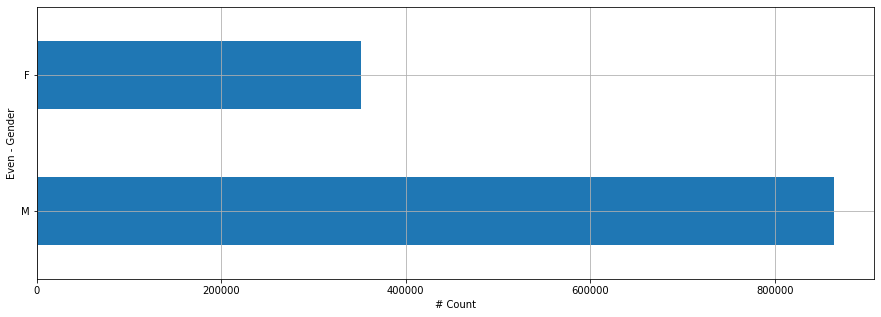

time: 835 ms (started: 2023-01-22 13:43:21 +00:00)


In [19]:
# Gender Value Counts
plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts().plot(kind='barh', grid=True)
plt.xlabel("# Count")
plt.ylabel("Even - Gender")

In [20]:
# Querying for required column(s)
selected_df = non_event_data_df.select(
    [
        pl.col("gender"),
    ]
)
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts()

M    47903
F    26741
Name: gender, dtype: int64

time: 44.2 ms (started: 2023-01-22 13:43:22 +00:00)


Text(0, 0.5, 'Non Event - Gender')

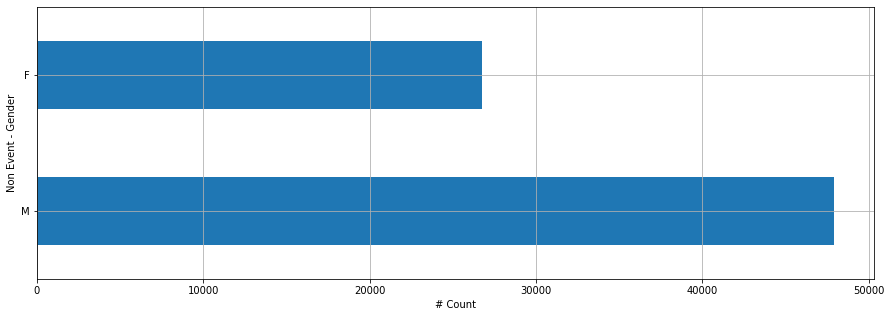

time: 209 ms (started: 2023-01-22 13:43:22 +00:00)


In [21]:
# Gender Value Counts
plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["gender"].value_counts().plot(kind='barh', grid=True)
plt.xlabel("# Count")
plt.ylabel("Non Event - Gender")

Text(0, 0.5, 'Event - Age')

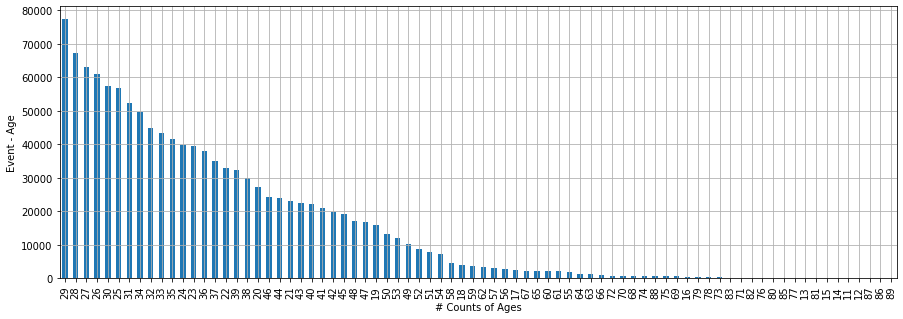

time: 1.46 s (started: 2023-01-22 13:43:22 +00:00)


In [22]:
# Age Value Counts

# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["age"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("# Counts of Ages")
plt.ylabel("Event - Age")

Text(0, 0.5, 'Non Event - Age')

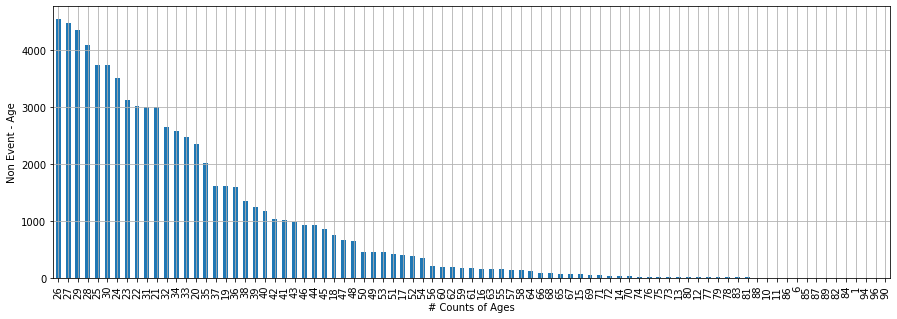

time: 996 ms (started: 2023-01-22 13:43:24 +00:00)


In [23]:
# Age Value Counts

# Querying for required column(s)
selected_df = non_event_data_df.select(
    [
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df.collect(streaming=True).to_pandas()["age"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("# Counts of Ages")
plt.ylabel("Non Event - Age")

In [24]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_df
gc.collect()

91

time: 102 ms (started: 2023-01-22 13:43:25 +00:00)


#### 2. Boxplot analysis for gender and age [bivariate].

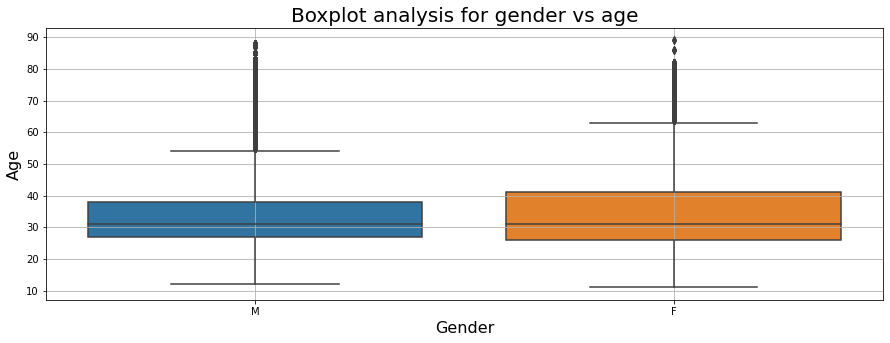

time: 1.28 s (started: 2023-01-22 13:43:25 +00:00)


In [25]:
# Querying for required column(s)
selected_df = event_data_df.select(
    [
        pl.col("gender"),
        pl.col("age"),
    ]
)

plt.figure(figsize=(15,5))
selected_df_pd = selected_df.collect(streaming=True).to_pandas()
sns.boxplot(data=selected_df_pd, x='gender', y='age')
plt.grid()
plt.title("Boxplot analysis for gender vs age", fontsize=20)      
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Age", fontsize=16)
plt.show()

In [26]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_df
del selected_df_pd
gc.collect()

3192

time: 107 ms (started: 2023-01-22 13:43:26 +00:00)


#### 3. Plot the percentage of the device_ids with and without event data

In [27]:
# Querying for required column(s)
temp_event_df = event_data_df.filter(pl.col("event_id") != None)
temp_event_df = temp_event_df.select(
    [
        pl.col("device_id").unique().alias("device_id"),
    ]
)
temp_non_event_df = non_event_data_df.select(
    [
        pl.col("device_id"),
        pl.col("device_id").is_in(temp_event_df.collect(streaming=True)["device_id"]).alias("has_event"),
    ]
)

time: 553 ms (started: 2023-01-22 13:43:26 +00:00)


In [28]:
temp_non_event_df.groupby(by='has_event').agg(pl.count()).collect(streaming=True).to_pandas()

,has_event,count
0,True,23309
1,False,51335


time: 43.5 ms (started: 2023-01-22 13:43:27 +00:00)


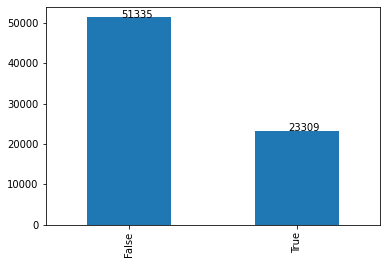

time: 135 ms (started: 2023-01-22 13:43:27 +00:00)


In [29]:
# Creating a countplot for question 3
ax = temp_non_event_df.collect(streaming=True).to_pandas().has_event.value_counts().plot(kind='bar')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.2, p.get_height()))

plt.show()

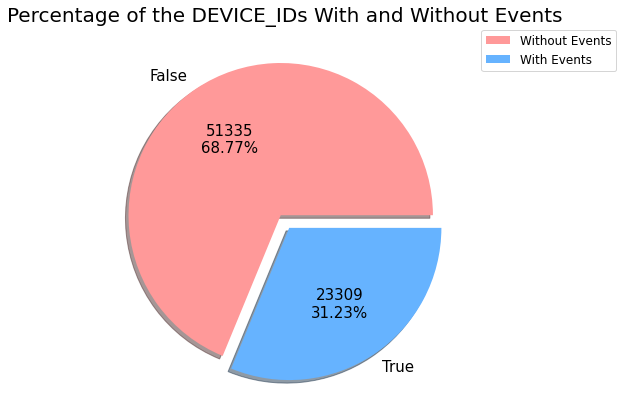

time: 152 ms (started: 2023-01-22 13:43:27 +00:00)


In [30]:
def label_function(val):
    return f'{val / 100 * len(temp_non_event_df.collect().to_pandas()):.0f}\n{val:.2f}%'

fig, ax = plt.subplots(ncols=1, figsize=(15, 7))

temp_non_event_df.collect(streaming=True).to_pandas().groupby('has_event') \
                    .size().plot(kind='pie', 
                                 autopct=label_function, 
                                 textprops={'fontsize': 15},
                                 colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'], 
                                 explode=[0.05, 0.05],
                                 shadow=True,
                                 ax=ax)
ax.legend(['Without Events', 'With Events'], 
          loc='best', 
          bbox_to_anchor=(1, 1.02), 
          fontsize='large')
ax.set_title("Percentage of the DEVICE_IDs With and Without Events", fontsize=20, pad=10)
plt.ylabel("")

plt.show()

In [31]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_event_df
del temp_non_event_df
gc.collect()

0

time: 112 ms (started: 2023-01-22 13:43:27 +00:00)


#### 4. Plot a graph representing the distribution of events over different days of a week.

In [32]:
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
event_data_df = event_data_df.select(
    [
        pl.col("*"),
        pl.col("time_stamp").dt.day().alias("day"),
        pl.col("time_stamp").dt.weekday().apply(lambda x: day_names[x-1]).alias("weekday"),
        pl.col("time_stamp").dt.month().alias("month"),
        pl.col("time_stamp").dt.hour().alias("hour"),
    ]
)

age_cat_df = pl.cut(event_data_df.collect(streaming=True)['age'], 
                     bins=[0, 24, 32, 45, 100], 
                     labels=["LOW", "0-24", "25-32", "33-45", "46+", "HIGH"])
age_cat_df = age_cat_df.select(pl.col('category').cast(pl.Utf8))
age_cat_df = age_cat_df.rename({'category': 'age_cat'})

event_data_df = event_data_df.with_column(age_cat_df['age_cat'])


time: 1.14 s (started: 2023-01-22 13:43:27 +00:00)


In [33]:
event_data_df.head().collect(streaming=True)

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude,day,weekday,month,hour,age_cat
i64,str,i64,str,i64,datetime[μs],f64,f64,u32,str,u32,u32,str
-7548291590301750000,"""M""",33,"""M32+""",2939192,2016-05-05 10:12:40,116.79,33.98,5,"""Thursday""",5,10,"""0-24"""
-7548291590301750000,"""M""",33,"""M32+""",2935402,2016-05-04 08:47:19,116.79,33.98,4,"""Wednesday""",5,8,"""0-24"""
-7548291590301750000,"""M""",33,"""M32+""",2906259,2016-05-01 11:00:08,116.79,33.98,1,"""Sunday""",5,11,"""0-24"""
-7548291590301750000,"""M""",33,"""M32+""",2904274,2016-05-01 10:15:23,116.79,33.98,1,"""Sunday""",5,10,"""0-24"""
-7548291590301750000,"""M""",33,"""M32+""",2897002,2016-05-04 03:33:24,116.79,33.98,4,"""Wednesday""",5,3,"""0-24"""


time: 1.05 s (started: 2023-01-22 13:43:28 +00:00)


In [34]:
# Querying for required column(s)
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
temp_event_df = event_data_df.filter(pl.col("weekday") != None) \
                                .groupby(by='weekday').agg(pl.col('device_id').count() \
                                    .alias('device_id_count'))   

time: 1.27 ms (started: 2023-01-22 13:43:29 +00:00)


In [35]:
print(temp_event_df.collect(streaming=True))

shape: (7, 2)
┌───────────┬─────────────────┐
│ weekday   ┆ device_id_count │
│ ---       ┆ ---             │
│ str       ┆ u32             │
╞═══════════╪═════════════════╡
│ Friday    ┆ 176657          │
│ Tuesday   ┆ 180296          │
│ Saturday  ┆ 166835          │
│ Monday    ┆ 169380          │
│ Sunday    ┆ 164017          │
│ Wednesday ┆ 178371          │
│ Thursday  ┆ 180041          │
└───────────┴─────────────────┘
time: 1.02 s (started: 2023-01-22 13:43:30 +00:00)


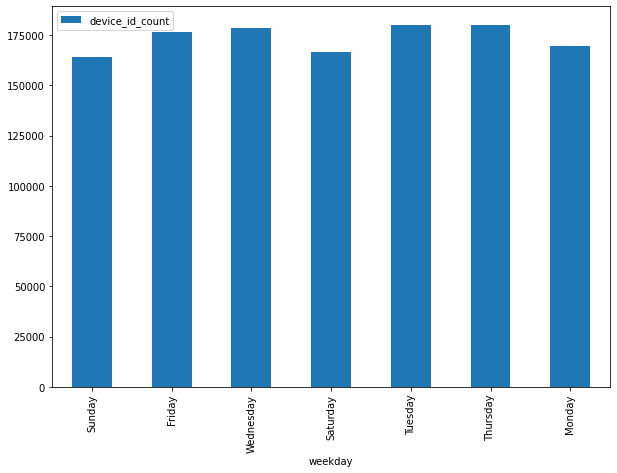

time: 1.19 s (started: 2023-01-22 13:43:31 +00:00)


In [36]:
temp_event_df.collect(streaming=True).to_pandas().plot.bar(x='weekday', y='device_id_count', figsize=(10, 7))
plt.show()

It seems that most events are happening on Tuesday, Wednesday, and Thursday whereas the least events are happening on Sunday.

In [37]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_event_df
gc.collect()

3021

time: 109 ms (started: 2023-01-22 13:43:32 +00:00)


#### 5. Plot a graph representing the distribution of events per hour [for one-week data]

In [38]:
# Filtering and getting one week data
from datetime import datetime

one_week_data_df = event_data_df.filter(pl.col("time_stamp").is_between(datetime(2016, 5, 1), 
                                                                        datetime(2016, 5, 8)))

time: 926 µs (started: 2023-01-22 13:43:32 +00:00)


In [39]:
print(f"Length of One Week DF: {len(one_week_data_df.collect(streaming=True))}")
print(f"Length of Entire DF: {len(event_data_df.collect(streaming=True))}")

Length of One Week DF: 1215214
Length of Entire DF: 1215597
time: 2.07 s (started: 2023-01-22 13:43:32 +00:00)


Almost all events have happened in the first week of May 2016. Continuing to find the hourly events

In [40]:
# Querying for required column(s)
temp_one_week_df = one_week_data_df.select(
    [
        pl.col('gender'),
        pl.col('age_cat'),
        pl.col('weekday'),
        pl.col('hour'),
    ]
)
temp_one_week_df_pd = temp_one_week_df.collect(streaming=True).to_pandas()

time: 1.11 s (started: 2023-01-22 13:43:34 +00:00)


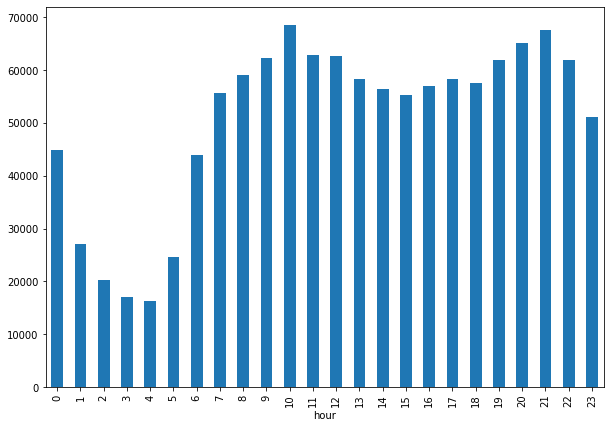

time: 246 ms (started: 2023-01-22 13:43:35 +00:00)


In [41]:
temp_one_week_df_pd.groupby('hour').size().plot(kind='bar',
                                                figsize=(10, 7))
plt.show()

The above graph shows that the maximum events occurred at 10 am in the morning and 9 pm in the event while the least events happened at 3 am and 4 am. Overall a lot of events happened at all times except between 1-5 am.

#### 6.The difference in the distribution of events per hour for Male and Female consumers. [Show the difference using an appropriate chart for one-week data.]

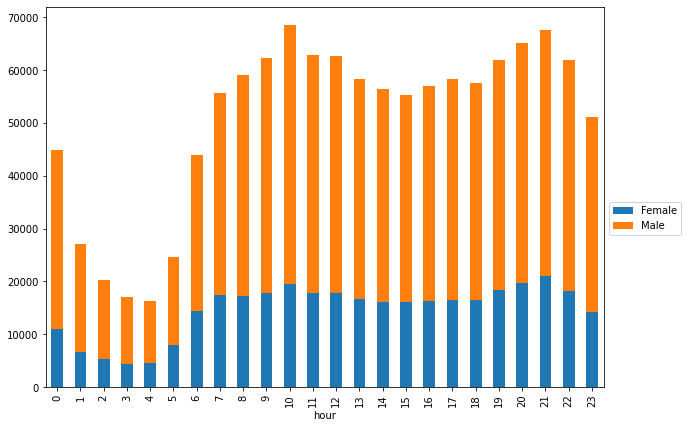

time: 543 ms (started: 2023-01-22 13:43:35 +00:00)


In [42]:
temp_one_week_df_pd.groupby('hour')['gender'].value_counts().unstack().plot(kind='bar',
                                                                            stacked=True,
                                                                            figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

Overall, men seem to be using phones more at late nights compared to women.

#### 7.Is there any difference in the distribution of Events for different Age Groups over different days of the week? [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

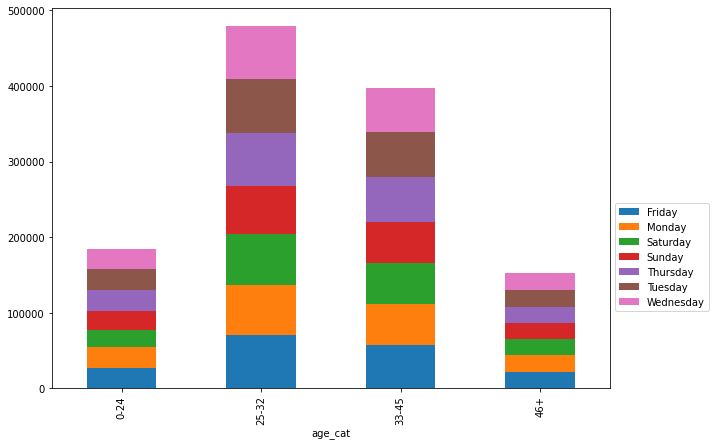

time: 514 ms (started: 2023-01-22 13:43:36 +00:00)


In [43]:
temp_one_week_df_pd.groupby('age_cat')['weekday'].value_counts() \
                    .unstack().plot(kind='bar', stacked=True, figsize=(10, 7))
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

From the above data we can only tell that Males overall access phones a lot compared to females. Both 32+ males and females access phones a lot on all days.

In [44]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_one_week_df
del temp_one_week_df_pd
gc.collect()

16555

time: 127 ms (started: 2023-01-22 13:43:36 +00:00)


#### 8.Stacked bar chart for the top 10 mobile brands across male and female consumers.

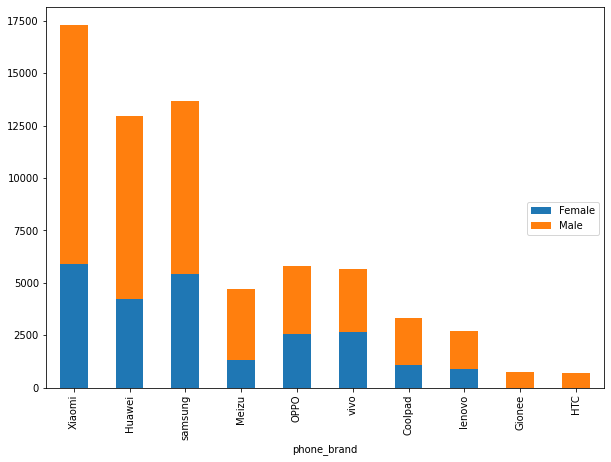

time: 261 ms (started: 2023-01-22 13:43:37 +00:00)


In [45]:
# Querying for required column(s)
temp_non_event_df = non_event_data_df.select(
    [
        pl.col('gender').alias('gender'),
        pl.col('phone_brand').alias('phone_brand'),
    ]
)
temp_non_event_df.collect(streaming=True).to_pandas().groupby('phone_brand')['gender'] \
                    .value_counts().sort_values(ascending=False).head(18) \
                        .unstack().plot(kind='bar', stacked=True, figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

The above graph shows that overall there are more male customers than female in the top 10 brands.

In [46]:
# Deleting `temp` variable(s) and running garbage collection.
del temp_non_event_df
gc.collect()

4078

time: 112 ms (started: 2023-01-22 13:43:37 +00:00)


#### 9. Prepare a chart representing the ten frequently used applications and their respective male and female percentage.

In [47]:
event_app_data_df = event_data_df.join(app_data_df, on='event_id')

time: 983 µs (started: 2023-01-22 13:43:37 +00:00)


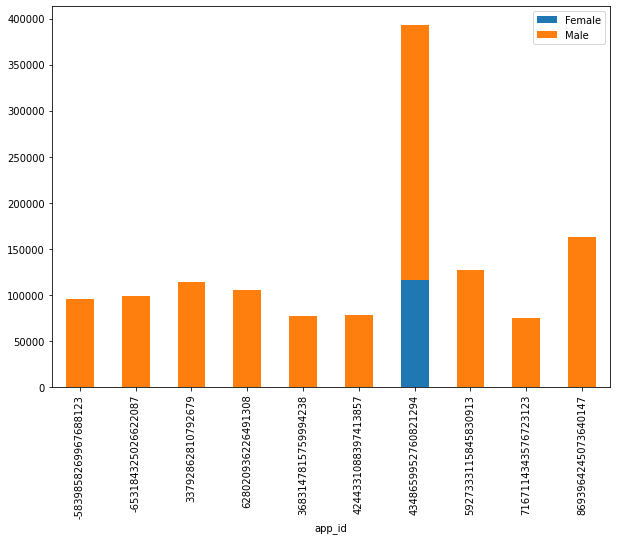

time: 10.1 s (started: 2023-01-22 13:43:37 +00:00)


In [48]:
# Querying for required column(s)
temp_event_app_data_df = event_app_data_df.select(
    [
        pl.col('app_id'),
        pl.col('gender'),
    ]
)

temp_df_pd = temp_event_app_data_df.groupby(by=['app_id', 'gender']) \
                                    .agg(pl.col('gender').count().alias('gender_count')) \
                                    .sort(by='gender_count', reverse=True) \
                                    .head(11).collect().to_pandas()
                                
pd.pivot_table(data=temp_df_pd, 
               index=['app_id'], 
               columns=['gender'], 
               values='gender_count') \
                    .plot.bar(stacked=True, 
                              figsize=(10, 7))
plt.legend(["Female", "Male"], loc='best')
plt.show()

The above graph tells us that barring the app with the highest users, the other top 10 apps are all mostly used by males

In [49]:
# Deleting `temp` variable(s) and running garbage collection.
del event_app_data_df
del temp_event_app_data_df
del temp_df_pd
gc.collect()

4119

time: 112 ms (started: 2023-01-22 13:43:47 +00:00)


#### 10. List the top 10 mobile phone brands bought by customers by age groups. [Consider the following age groups: 0–24, 25–32, 33–45, and 46+]

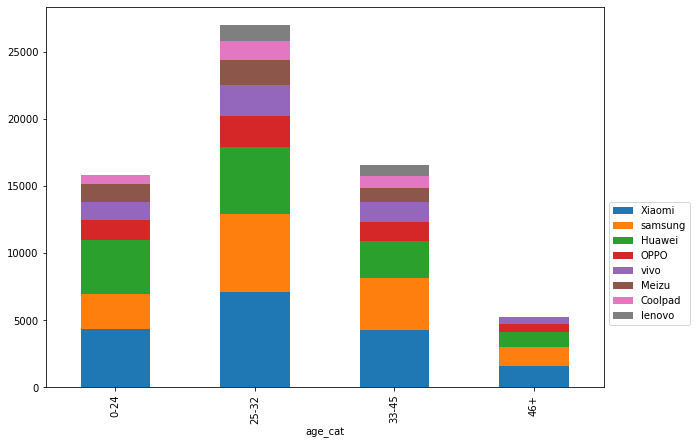

time: 292 ms (started: 2023-01-22 13:43:47 +00:00)


In [50]:
# Querying for required column(s)
age_cat_df = pl.cut(non_event_data_df.collect(streaming=True)['age'], 
                     bins=[0, 24, 32, 45, 100], 
                     labels=["LOW", "0-24", "25-32", "33-45", "46+", "HIGH"])
age_cat_df = age_cat_df.select(pl.col('category').cast(pl.Utf8))
age_cat_df = age_cat_df.rename({'category':'age_cat'})

non_event_data_df = non_event_data_df.with_column(age_cat_df['age_cat'])


temp_non_event_data_df = non_event_data_df.select(
    [
        pl.col('age'),
        pl.col('phone_brand'),
        pl.col('age_cat').cast(pl.Utf8),
    ]
)

temp_non_event_data_df.collect(streaming=True).to_pandas().groupby('age_cat')['phone_brand'] \
                        .value_counts().sort_values(ascending=False).head(28) \
                            .unstack().plot(kind='bar',
                                            stacked=True, 
                                            figsize=(10, 7))
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

In [51]:
# Deleting `temp` variable(s) and running garbage collection.
del age_cat_df
del temp_non_event_data_df
gc.collect()

5172

time: 113 ms (started: 2023-01-22 13:43:47 +00:00)


Overall the observation is that Xiaomi is the most preferred brand across all categories.

## Geo-Spatial Visualisation

### Plot the visualisation plot for a sample of 1 lakh data points

In [52]:
from mpl_toolkits.basemap import Basemap
%matplotlib inline

time: 359 ms (started: 2023-01-22 13:43:48 +00:00)


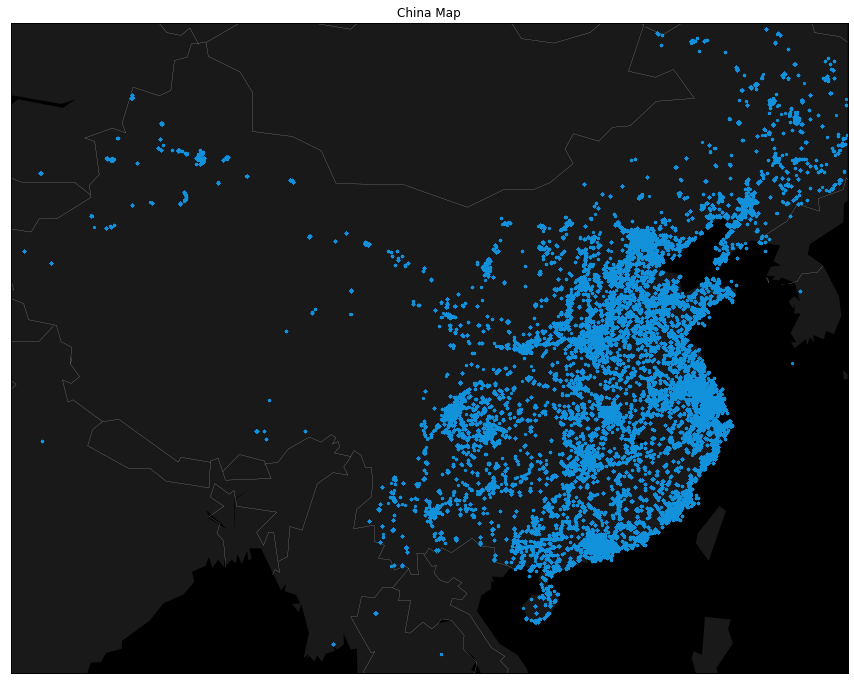

In [53]:
sample_event_data_df = event_data_df.collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_df_pd = sample_event_data_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_df_pd["longitude"].tolist(), 
        sample_event_data_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [54]:
# Deleting `temp` variable(s) and running garbage collection.
# del sample_event_data_df
del sample_event_data_df_pd
gc.collect()

26

The above map shows that most of the data points are concentrated in China.

### Compare the event visualisation plots based on the users' gender information. [This can be done on the sample of 1 lakh data points.]

time: 7.08 s (started: 2023-01-22 13:43:48 +00:00)
time: 133 ms (started: 2023-01-22 13:43:55 +00:00)


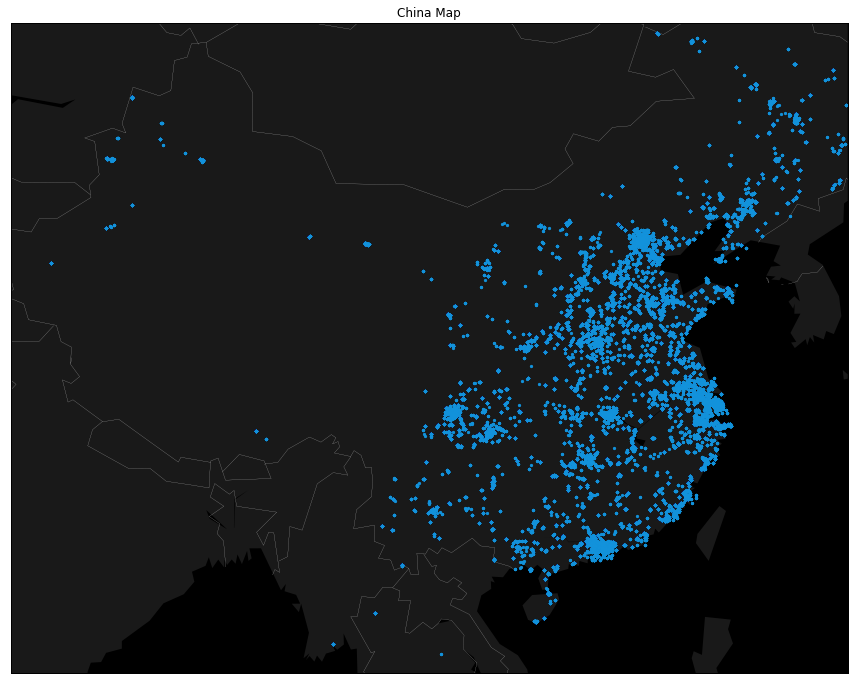

time: 3.08 s (started: 2023-01-22 13:43:55 +00:00)


In [55]:
sample_event_data_F_df = event_data_df.filter(pl.col('gender')=="F").collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_F_df_pd = sample_event_data_F_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_F_df_pd["longitude"].tolist(), 
        sample_event_data_F_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [56]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_event_data_F_df
del sample_event_data_F_df_pd
gc.collect()

2315

time: 122 ms (started: 2023-01-22 13:43:58 +00:00)


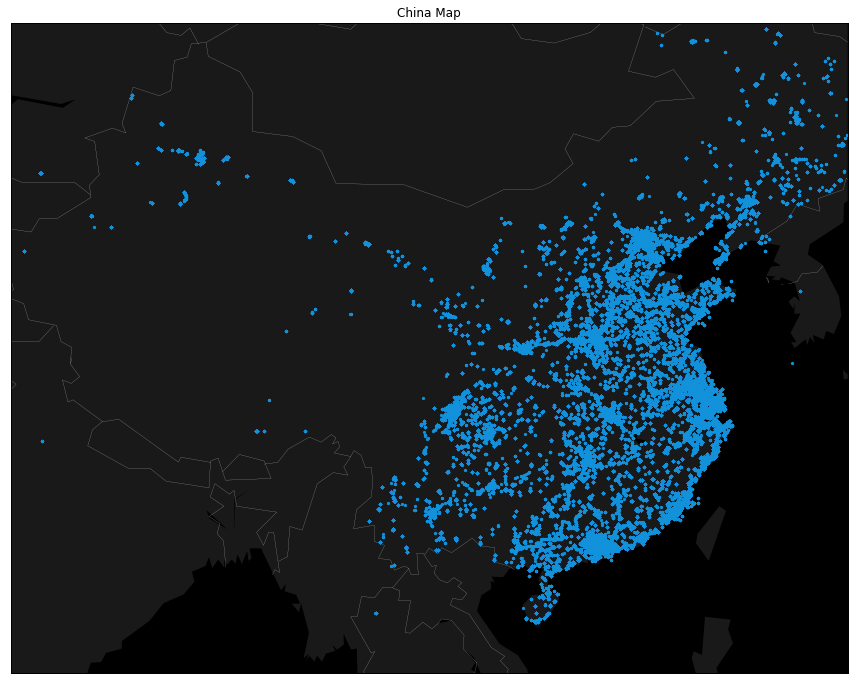

time: 5.42 s (started: 2023-01-22 13:43:58 +00:00)


In [57]:
sample_event_data_M_df = event_data_df.filter(pl.col('gender')=="M").collect(streaming=True)#.fetch(n_rows=100000)
sample_event_data_M_df_pd = sample_event_data_M_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_event_data_M_df_pd["longitude"].tolist(), 
        sample_event_data_M_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [58]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_event_data_M_df
del sample_event_data_M_df_pd
gc.collect()

2337

time: 150 ms (started: 2023-01-22 13:44:04 +00:00)


Can't say much based on the gender information except that the number of points for males are more than that of females.

### Compare the event visualisation plots based on the age groups

- 0–24 

- 25–32

- 32+

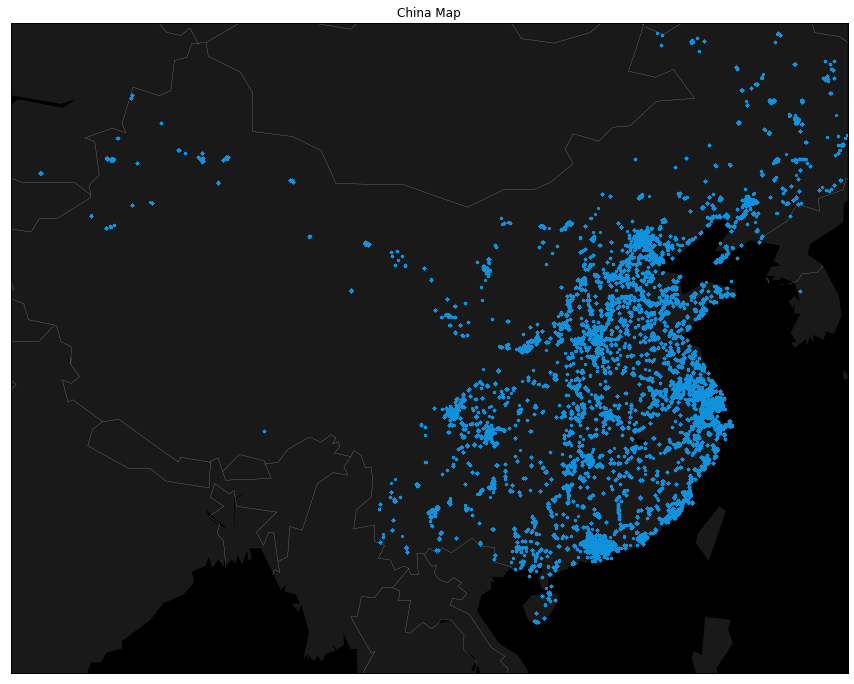

time: 3.98 s (started: 2023-01-22 13:44:04 +00:00)


In [59]:
sample_df = event_data_df.filter((pl.col('group_train') == "M32+") | 
                                 (pl.col('group_train') == "F32+")) \
                            .collect(streaming=True)#.fetch(n_rows=100000)
sample_df_pd = sample_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_df_pd["longitude"].tolist(), sample_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [60]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_df
del sample_df_pd
gc.collect()

2315

time: 135 ms (started: 2023-01-22 13:44:08 +00:00)


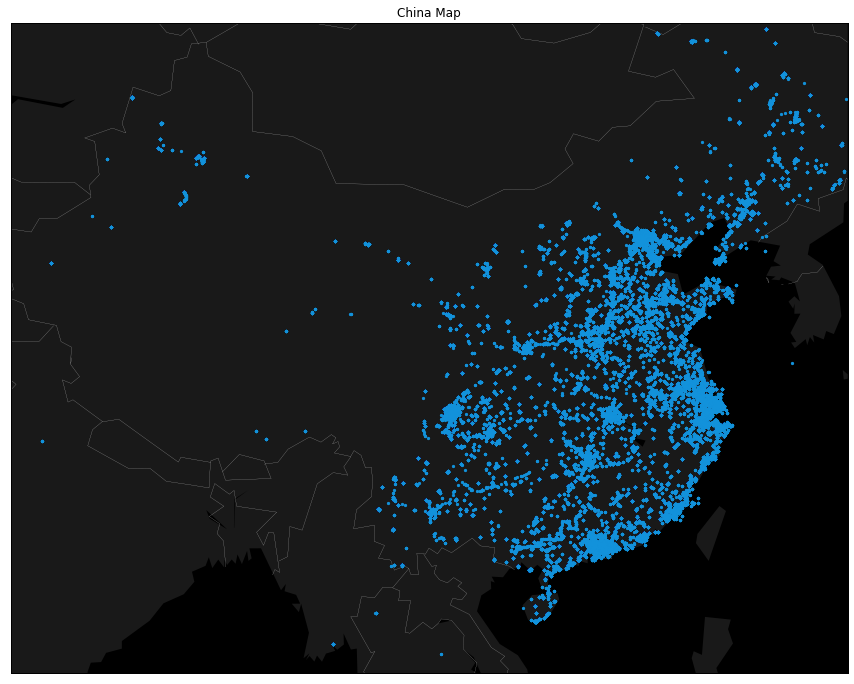

time: 3.6 s (started: 2023-01-22 13:44:08 +00:00)


In [61]:
sample_df = event_data_df.filter((pl.col('group_train') == "M25-32") | 
                                 (pl.col('group_train') == "F25-32")) \
                            .collect(streaming=True)#.fetch(n_rows=100000)
sample_df_pd = sample_df.to_pandas()

fig = plt.figure(figsize=(15, 15))

# Mercator of World
m = Basemap(projection='merc',
             llcrnrlat=15,  #latitude of lower left hand corner of the desired map domain
             urcrnrlat=50, #latitude of upper right hand corner of the desired map domain
             llcrnrlon=75, #longitude of lower left hand corner of the desired map domain
             urcrnrlon=130, #longitude of upper right hand corner of the desired map domain
             lat_ts=0, #latitude of true scale
             resolution='c') #resolution of boundary dataset being used - c for crude


m.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m.drawmapboundary(fill_color='#000000')                # black background
m.drawcountries(linewidth=0.15, color="w")              # thin white line for country borders

# Plot the data
mxy = m(sample_df_pd["longitude"].tolist(), sample_df_pd["latitude"].tolist())
m.scatter(mxy[0], mxy[1], s=5, c="#1292db", zorder=2)    # zorder for the points  

plt.title("China Map")
plt.show()

In [62]:
# Deleting `temp` variable(s) and running garbage collection.
del sample_df
del sample_df_pd
gc.collect()

2315

time: 135 ms (started: 2023-01-22 13:44:12 +00:00)


## Feature Engineering

### Feature Engineering on Events data

#### 1. Considering the events data, you can create a feature called Average Events, which can give you an estimate of how long the users' mobile phones are active.

In [63]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('event_id'),
    ]
)

unique_device_count = len(event_data_df.select([pl.col('device_id')]).unique().collect())

selected_features_df = selected_features_df.groupby('device_id') \
                                           .agg([pl.col('event_id').count()/unique_device_count])
selected_features_df = selected_features_df.rename({'event_id': 'device_avg_events'})

event_data_df = event_data_df.join(selected_features_df, on='device_id')

event_data_df = event_data_df.collect(streaming=True).lazy()

time: 2.18 s (started: 2023-01-22 13:44:12 +00:00)


In [64]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 120 ms (started: 2023-01-22 13:44:14 +00:00)


#### 2. You can use the information related to the location of the users (latitude and longitude data) to create features representing changes in the latitude and longitude details at different times of the day.

In [65]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('latitude'),
    ]
)

selected_features_df = selected_features_df.groupby('device_id').agg([pl.col('latitude').count()])
selected_features_df = selected_features_df.rename({'latitude': 'lat_long_count'})

event_data_df = event_data_df.join(selected_features_df, on='device_id')

event_data_df = event_data_df.collect(streaming=True).lazy()

time: 132 ms (started: 2023-01-22 13:44:14 +00:00)


In [66]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 132 ms (started: 2023-01-22 13:44:14 +00:00)


#### 3. You can create features such as Median Latitude and Median Longitude for different event ids.

In [67]:
# Querying for required column(s)
selected_features_df = event_data_df.select(
    [
        pl.col('device_id'),
        pl.col('latitude'),
        pl.col('longitude'),
    ]
)

median_lat_df = selected_features_df.groupby('device_id').agg([pl.col('latitude').median()])
median_lat_df = median_lat_df.rename({'latitude': 'device_median_latitude'})

median_long_df = selected_features_df.groupby('device_id').agg([pl.col('longitude').median()])
median_long_df = median_long_df.rename({'longitude': 'device_median_longitude'})

event_data_df = event_data_df.join(median_lat_df, on='device_id')
event_data_df = event_data_df.join(median_long_df, on='device_id')

event_data_df = event_data_df.collect(streaming=True).lazy()

time: 299 ms (started: 2023-01-22 13:44:14 +00:00)


In [68]:
# Deleting `temp` variable(s) and running garbage collection.
del selected_features_df
gc.collect()

0

time: 123 ms (started: 2023-01-22 13:44:15 +00:00)


#### Creating a new column for hour category

In [69]:
hour_cat_df = pl.cut(event_data_df.collect(streaming=True)["hour"],
                     bins=[-1, 3, 6, 11, 15, 20, 24],
                     labels=["LOW", "Late Night", "Early Morning", "Morning", 
                             "Afternoon", "Evening", "Night", "HIGH"])

hour_cat_df = hour_cat_df.select(pl.col('category').cast(pl.Utf8))
hour_cat_df = hour_cat_df.rename({'category': 'hour_cat'})

event_data_df = event_data_df.with_column(hour_cat_df['hour_cat'])

time: 101 ms (started: 2023-01-22 13:44:15 +00:00)


In [70]:
device_best_hour_df = event_data_df.groupby(by='device_id') \
                            .agg(pl.col('hour_cat').max().alias('device_best_hour'))

time: 825 µs (started: 2023-01-22 13:44:15 +00:00)


#### Creating a new column for best day for a device

In [71]:
device_best_day_df = event_data_df.groupby(by='device_id') \
                                .agg(pl.col('weekday').max().alias('device_best_day'))

time: 2.42 ms (started: 2023-01-22 13:44:15 +00:00)


### Feature Engineering on AppData

#### 4. You can also group the existing categories to create a new supercategory that will establish a significance in predicting the outcome variable.

In [72]:
def replace(column: str, mapping: dict) -> pl.Expr:
    if not mapping:
        raise Exception("Mapping can't be empty")
    elif not isinstance(mapping, dict):
        TypeError(f"mapping must be of type dict, but is type: {type(mapping)}")
    if not isinstance(column, str):
        raise TypeError(f"column must be of type str, but is type: {type(column)}")

    branch = pl.when(pl.col(column).str.to_lowercase().str.contains('|'.join(list(mapping.values())[0]))).then(
        list(mapping.keys())[0]
    )

    for to_value, from_value in mapping.items():
        branch = branch.when(pl.col(column).str.to_lowercase().str.contains('|'.join(from_value))).then(to_value)

    return branch.otherwise("Other").alias(column)


time: 4.03 ms (started: 2023-01-22 13:44:15 +00:00)


In [73]:
from_ = [["game", "free", "video", "fun", "lottery", "puzzle"], 
         ["community", "property"],
         ["joke", "comic", "passion", "lottery", "news", "music", "photo", "dance", "radio", "film"], 
         ["exercise", "parent", "baby", "child", "maternal", "insurance", "personal", "medical", "sport", "gym"], 
         ["equity", "broker", "card", "business", "industry", "job", "shares", "stock", "fund", "profit", "account", 
          "bank", "financ", "loan", "p2p", "Pay", "risk", "income", "debit", "credit", "securit"],
         ["recipe", "japan", "korea", "takeaway", "order"], 
         ["shop", "fashion", "cozy", "trend"], 
         ["church", "service"],
         ["aviation", "housing", "car", "train", "tour", "travel", "custom", "taxi", "book", "map"]]
to_ = ["Games", "Real Estate", "Entertainment", "Health", "Finance", "Food", "Shopping", "Religion", "Travel"]

from_to_mapping = {}
for from_val, to_val in zip(from_, to_):
    from_to_mapping[to_val] = from_val

time: 2.84 ms (started: 2023-01-22 13:44:15 +00:00)


In [74]:
# Querying for required column(s)
app_data_df = app_data_df.select(
    [
        pl.col('*'),
        pl.col('category').alias('super_category'),
    ]
)
    
app_data_df = app_data_df.with_column(replace('super_category', from_to_mapping))

time: 1.48 ms (started: 2023-01-22 13:44:15 +00:00)


In [75]:
# sample_app_df.head()
app_data_df.head().collect(streaming=True)

event_id,app_id,is_installed,is_active,label_id,category,super_category
i64,i64,i64,i64,i64,str,str
3127265,-5924787280098922359,1,1,548,"""Industry tag""","""Finance"""
3127265,-5924787280098922359,1,1,704,"""Property Indus...","""Real Estate"""
3127267,5927333115845830913,1,1,549,"""Property Indus...","""Real Estate"""
3127267,5927333115845830913,1,1,172,"""IM""","""Other"""
3127267,5927333115845830913,1,1,548,"""Industry tag""","""Finance"""


time: 1min 27s (started: 2023-01-22 13:44:15 +00:00)


In [76]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

0

time: 126 ms (started: 2023-01-22 13:45:42 +00:00)


## DBScan Clustering 

In [8]:
# coords_df = event_data_df.select(
#     [
#         pl.col('latitude').alias('lat'),
#         pl.col('longitude').alias('lon'),
#     ]
# ).filter(
#     ((pl.col('lat') < -1) | (pl.col('lat') > 1)) & \
#         ((pl.col('lon') < -1) | (pl.col('lon') > 1)) 
# )

time: 10.3 ms (started: 2023-01-22 17:18:23 +00:00)


In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import DistanceMetric

# kms_per_radian = 6371.0088
# epsilon = 40000 / kms_per_radian

# db = DBSCAN(eps=epsilon, 
#             min_samples=100, 
#             algorithm='ball_tree', 
#             metric='haversine').fit(np.radians(coords_df.collect().to_pandas()))

## Amalgamated Data Preparation

#### Merging Event and App Data

In [77]:
amalgamated_data_df = event_data_df.join(app_data_df, on="event_id", how="left")

time: 1.06 ms (started: 2023-01-22 13:45:42 +00:00)


In [78]:
amalgamated_data_df.head().collect(streaming=True)

device_id,gender,age,group_train,event_id,time_stamp,longitude,latitude,day,weekday,month,hour,age_cat,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,hour_cat,app_id,is_installed,is_active,label_id,category,super_category
i64,str,i64,str,i64,datetime[μs],f64,f64,u32,str,u32,u32,str,f64,u32,f64,f64,str,i64,i64,i64,i64,str,str
-7548291590301750000,"""M""",33,"""M32+""",2939192,2016-05-05 10:12:40,116.79,33.98,5,"""Thursday""",5,10,"""0-24""",0.012484,291,33.98,116.79,"""Late Night""",null,null,null,null,null,null
-7548291590301750000,"""M""",33,"""M32+""",2935402,2016-05-04 08:47:19,116.79,33.98,4,"""Wednesday""",5,8,"""0-24""",0.012484,291,33.98,116.79,"""Late Night""",null,null,null,null,null,null
-7548291590301750000,"""M""",33,"""M32+""",2906259,2016-05-01 11:00:08,116.79,33.98,1,"""Sunday""",5,11,"""0-24""",0.012484,291,33.98,116.79,"""Late Night""",null,null,null,null,null,null
-7548291590301750000,"""M""",33,"""M32+""",2904274,2016-05-01 10:15:23,116.79,33.98,1,"""Sunday""",5,10,"""0-24""",0.012484,291,33.98,116.79,"""Late Night""",null,null,null,null,null,null
-7548291590301750000,"""M""",33,"""M32+""",2897002,2016-05-04 03:33:24,116.79,33.98,4,"""Wednesday""",5,3,"""0-24""",0.012484,291,33.98,116.79,"""Late Night""",null,null,null,null,null,null


time: 1min 36s (started: 2023-01-22 13:45:42 +00:00)


In [79]:
show_missing_value_details(amalgamated_data_df)

device_id      : 0          : 0.00000%
gender         : 0          : 0.00000%
age            : 0          : 0.00000%
group_train    : 0          : 0.00000%
event_id       : 0          : 0.00000%
time_stamp     : 0          : 0.00000%
longitude      : 0          : 0.00000%
latitude       : 0          : 0.00000%
day            : 0          : 0.00000%
weekday        : 0          : 0.00000%
month          : 0          : 0.00000%
hour           : 0          : 0.00000%
age_cat        : 0          : 0.00000%
device_avg_events: 0          : 0.00000%
lat_long_count : 0          : 0.00000%
device_median_latitude: 0          : 0.00000%
device_median_longitude: 0          : 0.00000%
hour_cat       : 0          : 0.00000%
app_id         : 1137866    : 11.76442%
is_installed   : 1137866    : 11.76442%
is_active      : 1137866    : 11.76442%
label_id       : 1137866    : 11.76442%
category       : 1137866    : 11.76442%
super_category : 1137866    : 11.76442%
time: 1min 29s (started: 2023-01-22 13:47

#### Creating a new column for Super Category

In [80]:
# device_super_cat_df = amalgamated_data_df.groupby(by='device_id').agg(pl.col('super_category').max())

time: 1.18 ms (started: 2023-01-22 13:48:49 +00:00)


### Adding a new column number of apps open by device

In [81]:
device_app_count_df = amalgamated_data_df.groupby('device_id').agg(pl.col('app_id').unique().count() \
                                                             .alias('device_app_count')) \
                                            .sort('device_app_count', reverse=True)

time: 1.01 ms (started: 2023-01-22 13:48:49 +00:00)


### Removing all unnecessary columns before grouping dfead by device_id

In [85]:
amalgamated_data_df = amalgamated_data_df.drop(['event_id', 'group_train','time_stamp', 'longitude', 
                                                'latitude', 'day', 'weekday', 'hour', 'age_cat', 
                                                'hour_cat', 'app_id', 'is_installed', 'is_active', 
                                                'label_id', 'category'])

amalgamated_data_df = amalgamated_data_df.groupby(by='device_id').agg(pl.max('*'))

time: 1.33 ms (started: 2023-01-22 14:02:57 +00:00)


In [86]:
amalgamated_data_df.head().collect()

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category
i64,str,i64,u32,f64,u32,f64,f64,str
-6723936805271120000,"""F""",36,5,0.00266,62,0.0,0.0,"""Travel"""
4293283801686080000,"""M""",39,5,0.001973,46,33.86,113.5,"""Travel"""
-8798345393567260000,"""F""",36,5,0.000343,8,0.0,0.0,"""Travel"""
7189883679990040000,"""M""",30,5,0.000043,1,0.0,0.0,null
-4199010834745130000,"""F""",28,5,0.000043,1,0.0,0.0,null


time: 1min 37s (started: 2023-01-22 14:02:57 +00:00)


In [87]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

170

time: 241 ms (started: 2023-01-22 14:04:35 +00:00)


### Merging in all New Features

In [88]:
amalgamated_data_df = amalgamated_data_df.join(device_app_count_df, on='device_id', how='left')
# amalgamated_data_df = amalgamated_data_df.join(device_super_cat_df, on='device_id', how='left')
amalgamated_data_df = amalgamated_data_df.join(device_best_day_df, on='device_id', how='left')
amalgamated_data_df = amalgamated_data_df.join(device_best_hour_df, on='device_id', how='left')

time: 1.64 ms (started: 2023-01-22 14:04:36 +00:00)


In [89]:
amalgamated_data_df.head().collect(streaming=True)

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category,device_app_count,device_best_day,device_best_hour
i64,str,i64,u32,f64,u32,f64,f64,str,u32,str,str
-1542756295429230000,"""M""",31,5,0.008366,195,22.8,113.86,"""Travel""",39,"""Wednesday""","""Morning"""
-6059990871576130000,"""F""",31,5,0.000215,5,0.0,0.0,"""Travel""",6,"""Wednesday""","""Evening"""
653643854157662000,"""F""",40,5,0.001073,25,0.0,0.0,"""Travel""",27,"""Wednesday""","""Evening"""
4680052872615650000,"""M""",28,5,0.000129,3,0.0,0.0,"""Travel""",32,"""Wednesday""","""Evening"""
3993781485705560000,"""M""",19,5,0.000043,1,0.0,0.0,null,26,"""Wednesday""","""Night"""


time: 1min 30s (started: 2023-01-22 14:04:36 +00:00)


### Merging NonEvent Data to the Amalgamated DataFrame

In [90]:
non_event_data_df = non_event_data_df.drop(['gender', 'age', 'group_train','age_cat', 
                                            'super_category', 'device_model'])

amalgamated_data_df = amalgamated_data_df.join(non_event_data_df, on='device_id', how='left')

time: 1.22 ms (started: 2023-01-22 14:06:06 +00:00)


In [91]:
amalgamated_data_df.head().collect(streaming=True)

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,super_category,device_app_count,device_best_day,device_best_hour,phone_brand
i64,str,i64,u32,f64,u32,f64,f64,str,u32,str,str,str
-5999593545940270000,"""F""",35,5,0.003647,85,41.4,119.62,"""Travel""",17,"""Wednesday""","""Late Night""","""ccmc"""
-3002595526232980000,"""M""",31,5,0.004934,115,0.0,0.0,"""Travel""",40,"""Wednesday""","""Afternoon""","""Huawei"""
6436379939611380000,"""F""",31,5,0.000043,1,41.75,123.51,null,1,"""Saturday""","""Evening""","""Huawei"""
-6957350579117970000,"""F""",27,5,0.000515,12,0.0,0.0,"""Travel""",7,"""Wednesday""","""Afternoon""","""samsung"""
2582493193173190000,"""M""",33,5,0.000987,23,0.0,0.0,"""Travel""",36,"""Wednesday""","""Morning""","""vivo"""


time: 1min 32s (started: 2023-01-22 14:06:06 +00:00)


In [92]:
show_missing_value_details(amalgamated_data_df)

device_id      : 0          : 0.00000%
gender         : 0          : 0.00000%
age            : 0          : 0.00000%
month          : 0          : 0.00000%
device_avg_events: 0          : 0.00000%
lat_long_count : 0          : 0.00000%
device_median_latitude: 0          : 0.00000%
device_median_longitude: 0          : 0.00000%
super_category : 7772       : 33.34191%
device_app_count: 0          : 0.00000%
device_best_day: 0          : 0.00000%
device_best_hour: 0          : 0.00000%
phone_brand    : 1          : 0.00429%
time: 1min 29s (started: 2023-01-22 14:07:38 +00:00)


In [93]:
# Deleting `temp` variable(s) and running garbage collection.
del app_data_df
del event_data_df
del non_event_data_df
gc.collect()

0

time: 153 ms (started: 2023-01-22 14:09:07 +00:00)


## One-Hot Encoding

### Best Day and Hour for Device

In [94]:
amalgamated_data_df_pd = amalgamated_data_df.collect(streaming=True).to_pandas()
amalgamated_data_df = pl.from_pandas(pd.get_dummies(amalgamated_data_df_pd, columns=['device_best_day', 'device_best_hour'])).lazy()

time: 1min 31s (started: 2023-01-22 14:09:08 +00:00)


In [95]:
# Deleting `temp` variable(s) and running garbage collection.
del amalgamated_data_df_pd
gc.collect()

0

time: 154 ms (started: 2023-01-22 14:10:39 +00:00)


### Phone Brand and Super Category

In [96]:
top_10_phone_brands = ["xiaomi", "huawei", "samsung", "oppo", "meizu", "vivo", "coolpad", 
                       "lenovo", "lshi", "gionee", "htc", "nubia", "zte", "sony", "hammer"]
amalgamated_data_df = amalgamated_data_df.with_column(pl.col('phone_brand') \
                                                      .apply(lambda x: x if x.lower() in top_10_phone_brands else "Other").alias('phone_brand'))


time: 1.34 ms (started: 2023-01-22 14:10:39 +00:00)


In [97]:
amalgamated_data_df_pd = amalgamated_data_df.collect(streaming=True).to_pandas()

amalgamated_data_df = pl.from_pandas(pd.get_dummies(amalgamated_data_df_pd, columns=['phone_brand', 'super_category'])).lazy()

time: 51.2 ms (started: 2023-01-22 14:10:39 +00:00)


In [98]:
# Deleting `temp` variable(s) and running garbage collection.
del amalgamated_data_df_pd
gc.collect()

0

time: 138 ms (started: 2023-01-22 14:10:39 +00:00)


In [99]:
amalgamated_data_df.head().collect()

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,device_app_count,device_best_day_Friday,device_best_day_Monday,device_best_day_Saturday,device_best_day_Sunday,device_best_day_Thursday,device_best_day_Tuesday,device_best_day_Wednesday,device_best_hour_Afternoon,device_best_hour_Early Morning,device_best_hour_Evening,device_best_hour_Late Night,device_best_hour_Morning,device_best_hour_Night,phone_brand_Coolpad,phone_brand_Gionee,phone_brand_HTC,phone_brand_Huawei,phone_brand_Meizu,phone_brand_OPPO,phone_brand_Other,phone_brand_Sony,phone_brand_Xiaomi,phone_brand_ZTE,phone_brand_hammer,phone_brand_lenovo,phone_brand_lshi,phone_brand_nubia,phone_brand_samsung,phone_brand_vivo,super_category_Finance,super_category_Games,super_category_Other,super_category_Real Estate,super_category_Religion,super_category_Shopping,super_category_Travel
i64,str,i64,u32,f64,u32,f64,f64,u32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2539411400447300000,"""F""",26,5,0.000515,12,37.69,112.74,39,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2124665305128590000,"""F""",42,5,0.000172,4,42.25,123.77,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-4486982638449050000,"""M""",54,5,0.000129,3,36.78,118.02,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-8818349806372240000,"""F""",29,5,0.003132,73,29.54,106.53,17,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8794764447532580000,"""M""",30,5,0.006221,145,0.0,0.0,22,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


time: 10.2 ms (started: 2023-01-22 14:10:40 +00:00)


## Scaling Integer and Float Values 

In [106]:
from sklearn.preprocessing import StandardScaler

numerical_data_df_pd = amalgamated_data_df.select(
    [
        pl.col('device_avg_events'),
        pl.col('lat_long_count'),
        pl.col('device_median_latitude'),
        pl.col('device_median_longitude'),
        pl.col('device_app_count'),
    ]
).collect(streaming=True).to_pandas()


time: 18 ms (started: 2023-01-22 14:55:49 +00:00)


In [107]:
numerical_cols = ['device_avg_events', 'lat_long_count', 'device_median_latitude',
                  'device_median_longitude', 'device_app_count']

numerical_data_df_pd[numerical_cols] = StandardScaler().fit_transform(numerical_data_df_pd[numerical_cols])

for num_col in numerical_cols:
    amalgamated_data_df = amalgamated_data_df.with_column(pl.Series(num_col, 
                                                                    numerical_data_df_pd[num_col], 
                                                                    dtype=pl.Float32) \
                                                          .alias(num_col))

amalgamated_data_df.head().collect()

device_id,gender,age,month,device_avg_events,lat_long_count,device_median_latitude,device_median_longitude,device_app_count,device_best_day_Friday,device_best_day_Monday,device_best_day_Saturday,device_best_day_Sunday,device_best_day_Thursday,device_best_day_Tuesday,device_best_day_Wednesday,device_best_hour_Afternoon,device_best_hour_Early Morning,device_best_hour_Evening,device_best_hour_Late Night,device_best_hour_Morning,device_best_hour_Night,phone_brand_Coolpad,phone_brand_Gionee,phone_brand_HTC,phone_brand_Huawei,phone_brand_Meizu,phone_brand_OPPO,phone_brand_Other,phone_brand_Sony,phone_brand_Xiaomi,phone_brand_ZTE,phone_brand_hammer,phone_brand_lenovo,phone_brand_lshi,phone_brand_nubia,phone_brand_samsung,phone_brand_vivo,super_category_Finance,super_category_Games,super_category_Other,super_category_Real Estate,super_category_Religion,super_category_Shopping,super_category_Travel
i64,str,i64,u32,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
2539411400447300000,"""F""",26,5,-0.325239,-0.325239,1.531018,1.159909,0.734842,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2124665305128590000,"""F""",42,5,-0.390045,-0.390045,1.814873,1.355247,-0.86206,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-4486982638449050000,"""M""",54,5,-0.398146,-0.398146,1.474371,1.253416,-0.86206,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-8818349806372240000,"""F""",29,5,0.168908,0.168908,1.023689,1.049932,-0.18968,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8794764447532580000,"""M""",30,5,0.752163,0.752163,-0.815144,-0.836684,0.020439,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


time: 11.8 ms (started: 2023-01-22 14:55:51 +00:00)


In [109]:
# Deleting `temp` variable(s) and running garbage collection.
del numerical_data_df_pd
gc.collect()

155

time: 190 ms (started: 2023-01-22 15:01:50 +00:00)


### Converting gender into 0 and 1 form

In [115]:
amalgamated_data_df = amalgamated_data_df.with_column(pl.when(pl.col('gender') == 'M').then(0).otherwise(1))

gender,literal
str,i32
"""F""",1
"""F""",1
"""M""",0
"""F""",1
"""M""",0


time: 8.69 ms (started: 2023-01-22 15:09:04 +00:00)


In [116]:
# Deleting `temp` variable(s) and running garbage collection.
gc.collect()

271

time: 167 ms (started: 2023-01-22 15:11:01 +00:00)


## Splitting the Amalgamated Data based on Train Test Split

In [117]:
train_test_split_df = pl.scan_csv("train_test_split.csv")

time: 1.65 ms (started: 2023-01-22 15:14:06 +00:00)


In [119]:
selected_train_test_split_df = train_test_split_df.select(
    [
        pl.col('device_id'),
        pl.col('train_test_flag'),
    ]
)

amalgamated_data_df = amalgamated_data_df.join(selected_train_test_split_df, 
                                               on="device_id",
                                               how='left')


device_id,gender,age,group,train_test_flag
i64,str,i64,str,str
-7548291590301750000,"""M""",33,"""M32+""","""train"""
6943568600617760000,"""M""",37,"""M32+""","""train"""
5441349705980020000,"""M""",40,"""M32+""","""train"""
-5393876656119450000,"""M""",33,"""M32+""","""train"""
4543988487649880000,"""M""",53,"""M32+""","""train"""


time: 7.52 ms (started: 2023-01-22 15:14:26 +00:00)


In [120]:
amalgamated_data_df_train = amalgamated_data_df.filter(pl.col('train_test_flag') == 'train')
amalgamated_data_df_test = amalgamated_data_df.filter(pl.col('train_test_flag') == 'test')

time: 1.1 ms (started: 2023-01-22 16:53:15 +00:00)


In [121]:
amalgamated_data_df.collect(streaming=True).write_csv("AmalgamatedData.csv")

time: 136 ms (started: 2023-01-22 16:55:38 +00:00)
